Importing Libraries

Taking File input and resizing

In [73]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from calendar import c
import numpy as np

In [74]:

# img = cv2.imread(imgfile,0)
# print(np.max(img))
# cv2.imshow("window",img)
# cv2.waitKey()
# cv2.destroyAllWindows()

# img = cv2.resize(img, (size))


In [75]:
def initialize_centroids(k, data):
    centroids = np.zeros((k,3))
    for itr in range(k):
        i = np.random.randint(0,data.shape[0])
        j = np.random.randint(0,data.shape[1])
        centroids[itr] = data[i][j]
    return centroids

def calculate_error(a,b):
    l = 0.05
    return (a[0]-b[0])*(a[0]-b[0]) + (a[1]-b[1])*(a[1]-b[1]) + l*(a[2]-b[2])*(a[2]-b[2])

def assign_centroid(centroids,data):
    n_observations = data.shape[0]*data.shape[1]
    centroid_assign = []
    centroid_errors = []
    k = centroids.shape[0]

    for itri in range(data.shape[0]):
        for itrj in range(data.shape[1]):
            errors = np.array([])
            for centroid in range(k):
                error = calculate_error(centroids[centroid], data[itri][itrj])
                errors = np.append(errors, error)

            closest_centroid = np.where(errors == np.amin(errors))[0].tolist()[0]
            centroid_error = np.amin(errors)

            centroid_assign.append(closest_centroid)
            centroid_errors.append(centroid_error)
    return (centroid_assign, centroid_errors)

def update_centroids(centroids,centroid_assign,data,sz):
    sum = np.zeros((centroids.shape[0],3))
    freq = np.zeros((centroids.shape[0],1))
    for i in range(data.shape[0]*data.shape[1]):
        sum[centroid_assign[i]] += data[i//sz][i%sz]
        freq[centroid_assign[i]] += 1
    for i in range(centroids.shape[0]):
        if freq[i]!=0:
            sum[i] /= freq[i]
        else:
            sum[i] = centroids[i]
    return sum

def kmeans(k,data,sz):
    iterations = 10
    centroids = initialize_centroids(k,data)
    centroid_assign  = 0
    for i in range(iterations):
        
        (centroid_assign, centroid_errors)=assign_centroid(centroids,data)
        centroids = update_centroids(centroids,centroid_assign,data,sz)
    return (centroids,centroid_assign)

sz=10
size = (sz,sz)
clusters = size[0]*size[1]
imgfile = "sallu.jpeg"
img = cv2.imread(imgfile, cv2.IMREAD_GRAYSCALE)
sy = 100
img = cv2.resize(img,(sy,sy))
data = [[[i,j,img[i,j]] for j in range(img.shape[1])] for i in range(img.shape[0])]
data = np.array(data)
(avg,assign) = kmeans(clusters,data,sy)

# plt.imshow(img_)
# plt.show()
# cv2.waitKey()
# cv2.destroyAllWindows()


In [76]:
img_ = np.zeros((sy,sy))
ass_set = set(assign)
dic = {}
jit = 0
for iit in ass_set:
    dic[iit] = jit*255/len(ass_set)
    jit = jit+ 1
for i in range(len(assign)):
    img_[i//sy][i%sy] = dic[assign[i]]


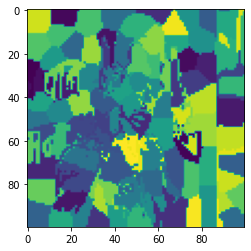

In [77]:
plt.imshow(img_)
plt.show()

From Image to Graph

In [78]:
def lambdai(g, mean1, variance1, mean2, variance2):
    p1= np.exp(-(g-mean1)*(g-mean1)/(2*variance1))
    p2= np.exp(-(g-mean2)*(g-mean2)/(2*variance2))
    return np.log(p1)-np.log(p2)

def calculate_error(a,b):
    l = 2
    return np.sqrt((a[0]-b[0])*(a[0]-b[0]) + (a[1]-b[1])*(a[1]-b[1]) + l*(a[2]-b[2])*(a[2]-b[2]))

def constructGraph(AdjMat, mean1, mean2, variance1, variance2,avg):
    N = AdjMat.shape[0]  
    #edges between s/t and vertices
    AdjMat[N-2] = 0
    AdjMat[N-1] = 0
    AdjMat[:,N-2] = 0
    AdjMat[:,N-1] = 0
    for i in range(N-2):
        lambda_i= lambdai(avg[i][2],mean1, variance1, mean2, variance2)
        if lambda_i>0.001 :
                AdjMat[N-2][i] = lambda_i
        elif lambda_i < -0.001:
                AdjMat[i][N-1] = -lambda_i
    # for i in range(row):
    #     for j in range(col):
    #         #calculation of lambda(i)
    #         lambda_i= lambdai(img[i][j],mean1, variance1, mean2, variance2)
    #         if(lambda_i>0):
    #             AdjMat[n-2][i*col+j] = lambda_i
    #         else:
    #             AdjMat[i*col+j][n-1] = -lambda_i
    return AdjMat  


In [79]:
def calculate_min_cut(N,G):
    def there_is_overflowing_vertex(arr):
        for i in range(len(arr)):
            if arr[i] > 0:
                return True
        return False

    def overflowing_vertex(arr):
        x = np.where(arr>0)
        return x[0][0]

    def add_flow(Residual_graph,Excess_flows,u,v,delta,Flows):
        Residual_graph[u][v] -= delta
        Residual_graph[v][u] += delta
        Excess_flows[u] -= delta
        Flows[u][v] += delta
        if Residual_graph[v,u] > Flows[v,u]:
            Flows[v][u] -= delta
        else:
            Flows[v][u] = 0
            Residual_graph[v][u] = delta
        if(v<len(Excess_flows)):
            Excess_flows[v] += delta

    def Find_push_vertex(u,Residual_graph,heights):
        v = np.where((Residual_graph[u]>0) & (heights[u]>heights))
        return v

    def push(u,Residual_graph,Excess_flows,heights,Flows):
        v_arr = Find_push_vertex(u,Residual_graph,heights)
        if(len(v_arr[0])):
            v = v_arr[0][0]
            Push_val = min(Excess_flows[u],Residual_graph[u][v])
            add_flow(Residual_graph,Excess_flows,u,v,Push_val,Flows)
            return True
        else:
            return False

    def Relable(u,Residual_graph,heights):
        heights[u] = 1 +  np.min(heights[np.where(Residual_graph[u]>0)])    

    # def generate_graph(N):
    #     b = np.random.randint(2, size=(N, N))
    #     b[N-1] = 0
    #     b[:,N-2] = 0
    #     temp = np.ones(N)
    #     temp = -1*np.diag(temp)
    #     temp = temp + np.ones((N,N))
    #     adj_mat = b*temp
    #     edge_capacities = adj_mat*np.random.randint(21, size=(N, N))
    #     return edge_capacities

    def dfs(rGraph, V, s, visited):
        stack = [s]
        while stack:
            v = stack.pop()
            if not visited[v]:
                visited[v] = True
                stack.extend([u for u in range(V) if rGraph[v][u] > 0])

    np.random.seed(3)
    # N = 6

    # Original_graph = generate_graph(N)
    # Original_graph = np.array([[0,10,12,0,0,0],[4,0,0,14,0,0],[0,9,0,0,0,20],[0,0,7,0,0,4],[16,13,0,0,0,0],[0,0,0,0,0,0]])
    Original_graph = G
    # Original_graph = np.array([[0,1,0,0],[0,0,0,2],[3,0,0,0],[0,0,0,0]])

    #---------------------Variables Required-----------------------------#
    Residual_graph = np.copy(Original_graph)
    Flows = np.zeros((N,N))     #Assumed Redundant
    Excess_flows = np.zeros(N-2)
    Heights = np.zeros(N)
    print(Original_graph)
    #----------------------Pre-Flow----------------------------#
    Heights[N-2] = N #Height of source = #Vertex
    Excess_flows = np.copy(Residual_graph[N-2,:N-2])
    Flows[N-2,:] = np.copy(Residual_graph[N-2,:])
    Flows[:,N-2] = np.transpose(-Residual_graph[N-2,:])
    Residual_graph[:,N-2] = np.transpose(Residual_graph[N-2,:])
    Residual_graph[N-2] = 0
    #----------------------Main Loop----------------------------#
    while(there_is_overflowing_vertex(Excess_flows)):
        # print("-------------------------------------------------")
        # print("Heights: ",Heights)
        u = overflowing_vertex(Excess_flows)
        if(not push(u,Residual_graph,Excess_flows,Heights,Flows)):
            Relable(u,Residual_graph,Heights)
    # print("Max Flow: ",np.sum(Residual_graph[N-1]),np.sum(Residual_graph[:,N-2]))
    #-----------------------------------------------------------#
    print(np.transpose(Residual_graph))
    print(Heights)
    print(Flows)
    # Flow = np.copy(Residual_graph-np.transpose(Residual_graph))
    # # print(Flow)
    # Flow[np.where(Flow<0)] = 0
    # print(Flow)
    visited = np.zeros(N, dtype=bool)
    dfs(Residual_graph - Flows, N, N-2, visited)
    return visited


In [80]:
def parUpdate(AdjMat,avg):
    b_arr = calculate_min_cut(len(AdjMat),AdjMat)
    N = AdjMat.shape[0]
    mean1_ = 0
    mean2_ = 0
    variance1_ = 0
    variance2_ = 0
    for i in range(len(b_arr)-2):
        if b_arr[i]:
                mean2_ += avg[i][2] 
        else:
                mean1_ += avg[i][2]
    true_freq = np.count_nonzero(b_arr) -1
    false_freq = len(b_arr) -1 - true_freq
    mean1_ /= false_freq
    mean2_ /= true_freq

    for i in range(len(b_arr)-2):
        if b_arr[i]:
            variance2_ += (avg[i][2]-mean2_)*(avg[i][2]-mean2_)
        else:
            variance1_ += (avg[i][2]-mean1_)*(avg[i][2]-mean1_)
    
    variance2_ /= true_freq
    variance1_ /= false_freq
    return (mean1_,mean2_,variance1_,variance2_,b_arr)

In [81]:
V = len(avg) + 2    # No. of Vertices = No. of SuperPixels + 's' + 't'
AdjMat = np.zeros((V, V), dtype='int32')
c=100
#edges between neighbors
for k in range(len(avg)):
    for l in range(len(avg)):
        if k != l and calculate_error(avg[k],avg[l])<c:
            AdjMat[k][l] = 0.25

# for i in range(row):
#     for j in range(col):
#         vertex1 = i*col + j
#         for k in range(row):
#             for l in range(col):
#                 vertex2 = k*col + l
#                 #check if neighbors
#                 if (not (vertex1 == vertex2) and (calculate_error(avg[assign[vertex1]],avg[assign[vertex2]])<c)):
#                     AdjMat[vertex1][vertex2] = 0.25

mean1 = 50
mean2 = 200
variance1 = 10000
variance2 = 10000
b_arr = np.zeros(V, dtype=bool)
for itr in range(10):
    AdjMat = constructGraph(AdjMat,mean1,mean2,variance1,variance2,avg)
    (mean1,mean2,variance1,variance2,b_arr) = parUpdate(AdjMat,avg)

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 1]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 1 0 0]
 [0 0 0 ... 0 0 0]]
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 1 0]
 [0 0 0 ... 0 0 0]
 [0 0 1 ... 0 0 0]]
[  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0. 103. 103.   0.   0.   0.   0.   0.   0.   0. 103.   0.   0.   0.
   0.   0. 103.   0. 103.   0.   0. 103.   0. 103.   0.   0.   0.   0.
   0.   0.   0. 103.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0. 103.   0. 103.   0.   0.   0.
   0.   0.   0.   0.   0. 103.   0.   0.   0.   0.   0.   0. 103.   0.
   0.   0.   0. 103. 103.   0.   0. 103.   0. 103.   0.   0.   0.   0.
   0. 103. 102.   0.]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 ...
 [ 0 

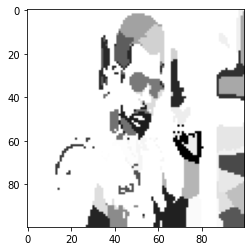

In [82]:
black = []
for i in range(len(assign)):
    if b_arr[assign[i]]:
        black.append(i)
for index in black:
    i = index//img_.shape[0]
    j = index%img_.shape[0]
    img_[i][j] = 255

plt.imshow(img_,cmap='gray')
plt.show()